In [76]:
import os
import librosa
import librosa.display
import json 
import importlib
import formExtractor as fem
importlib.reload(fem)
import matplotlib.pyplot as plt

In [77]:
import numpy as np
np.version.version

'1.24.4'

In [78]:
def load_audio_files(path):
    audio_files = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".mp3"):
                audio_files.append(os.path.join(root, file))
    return audio_files

In [79]:
#define the collection
collection = 'lastfm' #lastfm, suno, udio

#path to the folder containing the audio files
path = '../samples/'
song_files = path + collection + "_samples" + '/audio'
files = load_audio_files(song_files)
print(collection, len(files), "files found")

lastfm 20 files found


In [80]:
id = 1
song = files[id]
song

'../samples/lastfm_samples/audio/2e7c3fbecc1161b4f4c530320a73b86d.mp3'

In [81]:
# print metadata
id_file = song.split('/')[-1].split('.')[0]
md = path + collection + "_samples" + '/metadata/' + id_file + '.json'

with open(md) as json_file:
    data = json.load(json_file)
    
    # Calculate the maximum key length
    max_key_length = max(len(key) for key in data.keys())
    
    # Print each line with keys aligned
    for key in data:
        print(f"{key:{max_key_length}} : {data[key]}")

id_dataset          : 2e7c3fbecc1161b4f4c530320a73b86d
id_spotify          : 1abbuD7fU8Ltd51PKLcdD3
url_spotify_preview : https://p.scdn.co/mp3-preview/798fc011f140d6e0ec8e4e48069e4c1a2874b32f?cid=774b29d4f13844c495f206cafdad9c86
url_lastfm          : https://www.last.fm/music/Robyn/_/U+Should+Know+Better
artist              : Robyn
name                : U Should Know Better
youtube_url         : https://www.youtube.com/watch?v=CfffPI42KX8
tags                : ['swedish', 'electropop', 'pop', 'electronic']
duration            : 326.426009


In [82]:
#use the segmented audio file

audio_source = 'bass' + '.wav' #vocals, drums, bass, other
harmony = path + collection + "_samples" + '/segmented/' + id_file + '/' + audio_source
print(harmony)

song = harmony

../samples/lastfm_samples/segmented/2e7c3fbecc1161b4f4c530320a73b86d/bass.wav


In [83]:
formData = fem.formExtractor()

y, sr = librosa.load(song)

In [84]:
# Extract chroma features
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
# Aggregate chroma features by averaging over time
chroma_mean = np.mean(chroma, axis=1)

In [85]:
# Krumhansl-Schmuckler key profiles
major_profile = np.array([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52,
                          5.19, 2.39, 3.66, 2.29, 2.88])

minor_profile = np.array([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54,
                          4.75, 3.98, 2.69, 3.34, 3.17])

In [86]:
# Initialize lists to store correlation scores
correlations = []

# Iterate over all 12 keys
keys = ['C', 'C#', 'D', 'D#', 'E', 'F',
        'F#', 'G', 'G#', 'A', 'A#', 'B']
modes = ['major', 'minor']

for i, key in enumerate(keys):
    # Rotate the key profiles to match the current key
    rotated_major = np.roll(major_profile, i)
    rotated_minor = np.roll(minor_profile, i)
    
    # Compute correlations
    corr_major = np.corrcoef(chroma_mean, rotated_major)[0, 1]
    corr_minor = np.corrcoef(chroma_mean, rotated_minor)[0, 1]
    
    correlations.append((f"{key} major", corr_major))
    correlations.append((f"{key} minor", corr_minor))

# Sort keys by correlation score
correlations.sort(key=lambda x: x[1], reverse=True)

# Print top 5 key suggestions
print("Top 5 key detections:")
for key, score in correlations[:5]:
    print(f"{key}: {score:.4f}")

#get the first tonality in the list
tonality = correlations[0][0]


Top 5 key detections:
A minor: 0.5840
C minor: 0.5759
C major: 0.4674
G# major: 0.4548
F minor: 0.3385


In [87]:
C = formData.amplitud_to_db(y, sr, False)

In [88]:
#this_path = 'path + collection + "_samples" + '/form/'
#K = 2
#data_dict = formData.getFormAndSave(K, song, id_file, this_path)

# Call the plotSpectrogram function
#plotMe.plotSpectrogram(sr, C, chords, bars, bound_frames, new_bound_segs, BINS_PER_OCTAVE, 40, 5)

#plotMe.plotWaveform(y, data_dict['sr'], data_dict['chords'], data_dict['bars'], data_dict['bound_frames'], data_dict['bound_segs'], 40, 5) #last two numbers are the size of the plot in inches


In [89]:
Csync, beats, beat_times = formData.sync(y, sr, C)

Threshold: 0.0


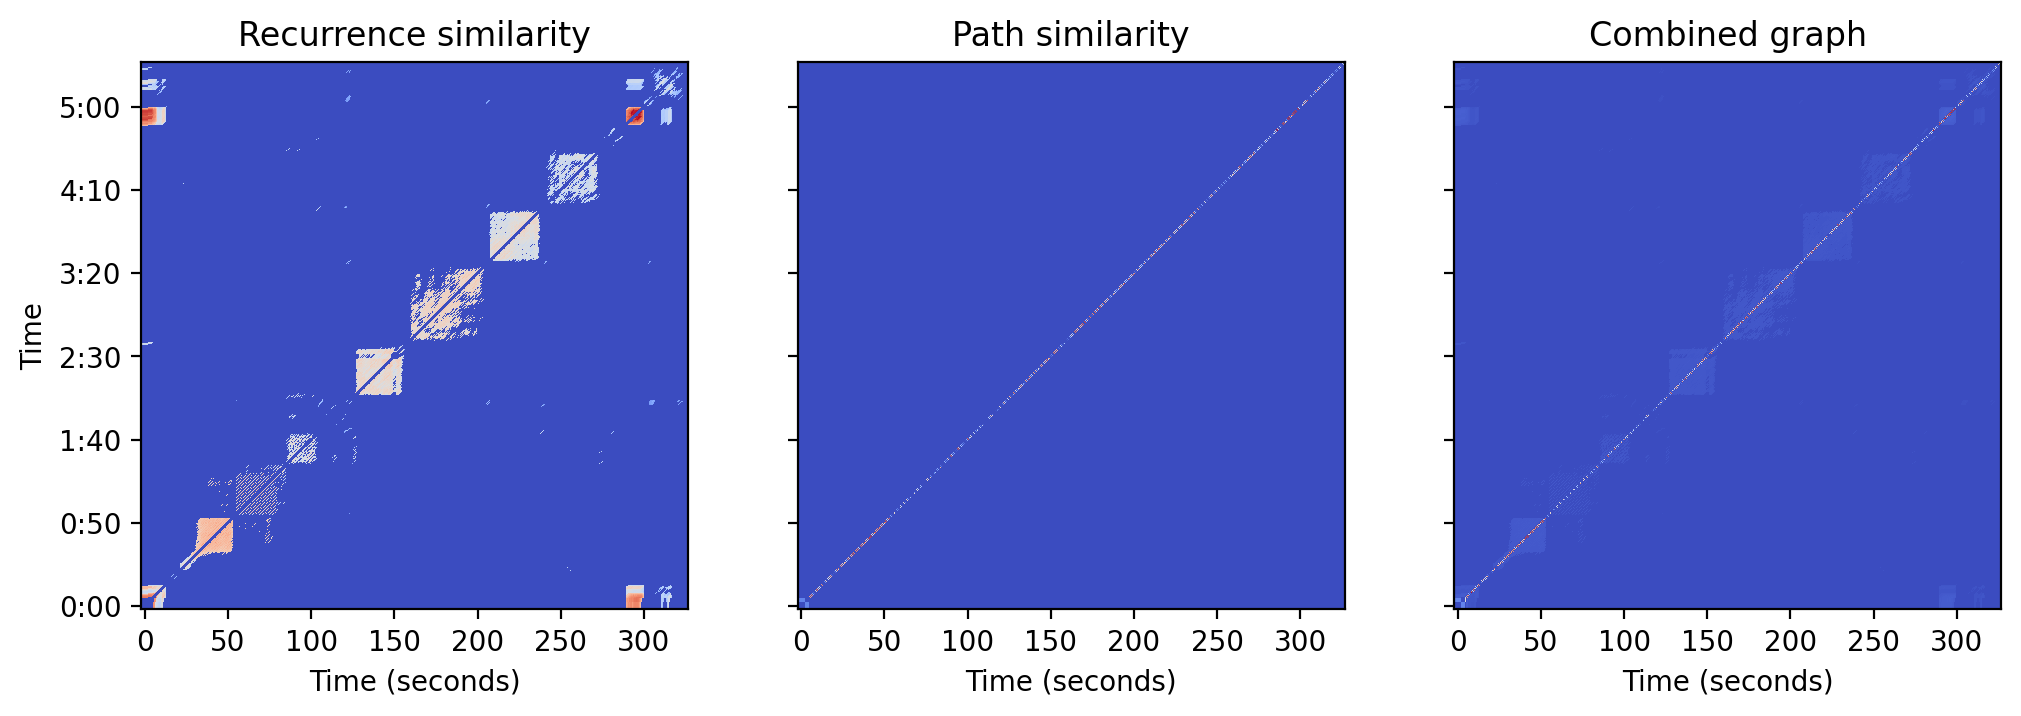

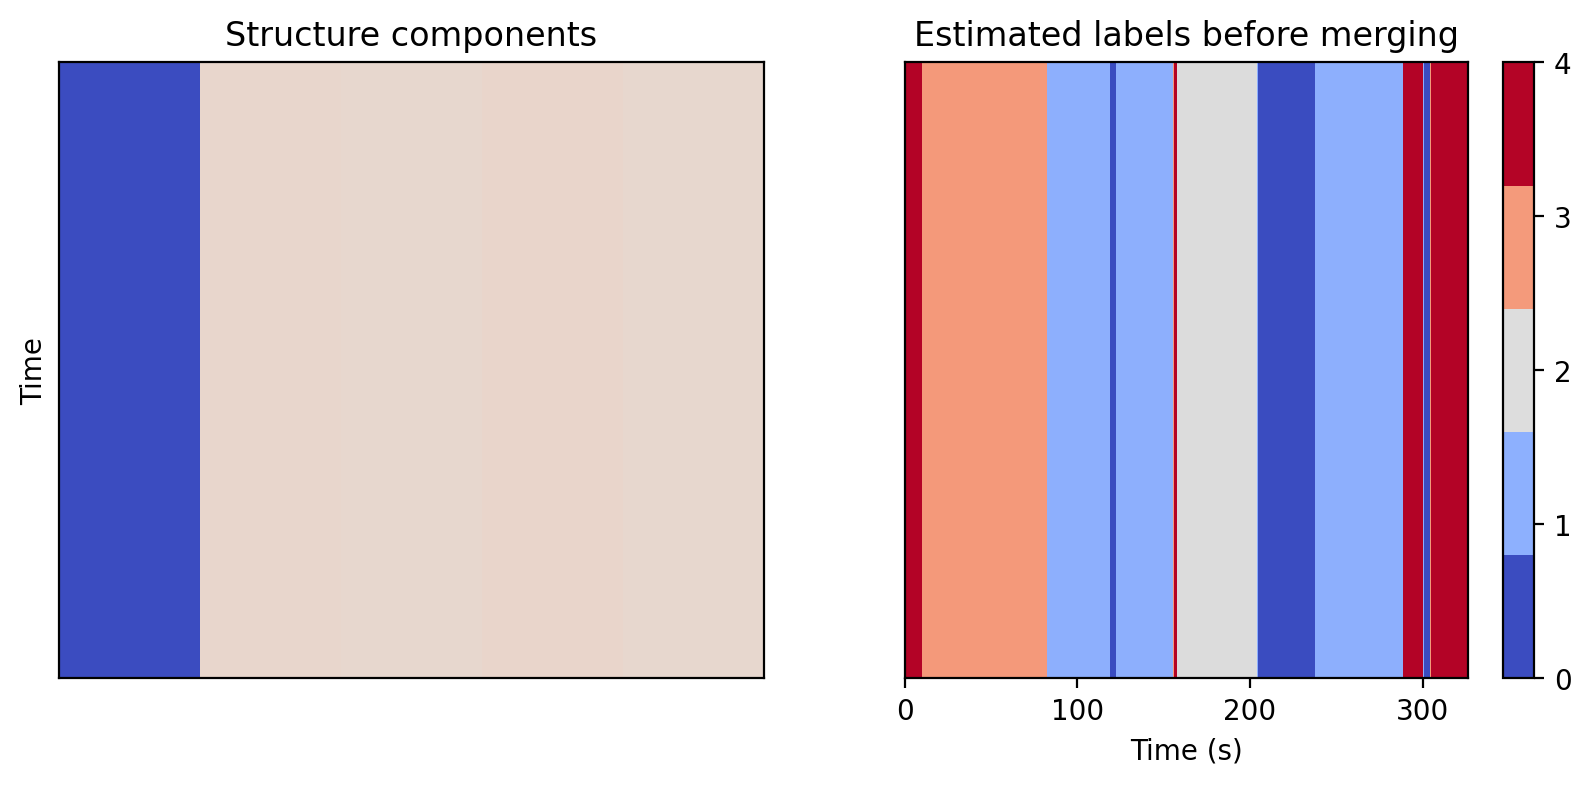

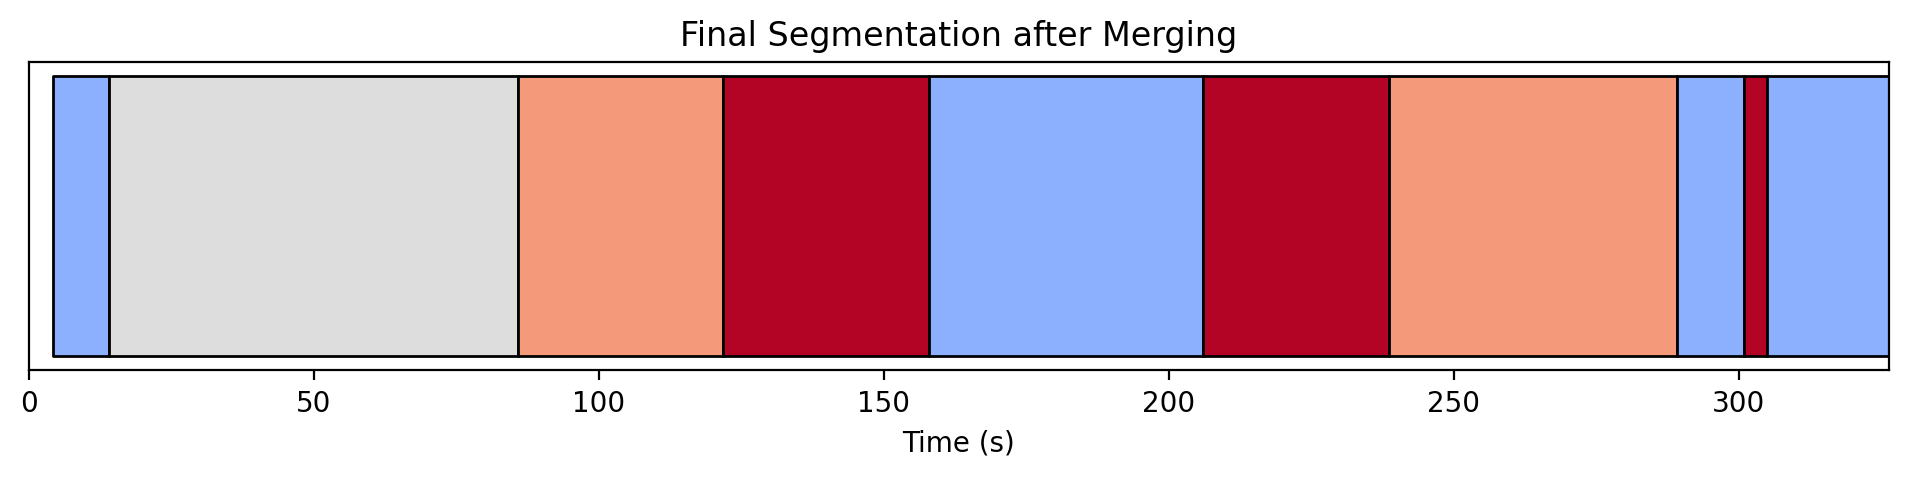

In [102]:
import formExtractor as fem

# Recreate the instance after reloading
formData = fem.formExtractor()

K = 5 #If we want k clusters, use the first k normalized eigenvectors.
min_duration = 3.5  # Minimum segment duration in seconds

#bound_frames, bound_segs = formData.laplacian(y, sr, C, Csync, beats, beat_times, K, True, 0.0) #True to plot the laplacian

bound_frames, bound_segs = formData.laplacian_2(y, sr, C, Csync, beats, beat_times, K, plotIt=True, min_duration=min_duration)

In [103]:
# get triads
chord_progression = formData.getChords(song)
bars = formData.getBars(song)

print(chord_progression)
#print the chords and the bars
# for chord in chord_progression:
#     print(chord)

{'useNNLS': 1, 'rollon': 1, 'tuningmode': 1, 'whitening': 0.8, 's': 0.6, 'boostn': 0.1}
[ChordChange(chord='N', timestamp=0.371519274), ChordChange(chord='Gmaj7', timestamp=15.046530612), ChordChange(chord='A', timestamp=15.696689341999999), ChordChange(chord='Bb', timestamp=16.346848072), ChordChange(chord='B', timestamp=17.182766439), ChordChange(chord='Cm', timestamp=18.854603174), ChordChange(chord='Abmaj7', timestamp=19.78340136), ChordChange(chord='C', timestamp=21.269478458), ChordChange(chord='Abmaj7', timestamp=29.257142857), ChordChange(chord='Gaug', timestamp=39.102403628), ChordChange(chord='G7', timestamp=50.15510204), ChordChange(chord='Ab6', timestamp=58.79292517), ChordChange(chord='G7', timestamp=59.535963718), ChordChange(chord='Fm7', timestamp=79.598004535), ChordChange(chord='Abmaj7', timestamp=85.82095238), ChordChange(chord='Aaug', timestamp=87.399909297), ChordChange(chord='C', timestamp=88.793106575), ChordChange(chord='Abmaj7', timestamp=89.257505668), ChordCha

In [104]:
# Correct sharp or flat tonality
# Import your Transposition class
from transposition import Transposition

# Initialize the Transposition object
transposer = Transposition()

# Use the get_alterations_scales method to get alterations
corrected_tonality, alterations, scale = transposer.get_alterations_scales(tonality)

# Print the output
print(f"Tonality: {corrected_tonality}")
print(f"Alterations: {alterations}")
print(f"Scale: {scale}")

tonality = corrected_tonality

Tonality: F minor
Alterations: ['Bb', 'Eb', 'Ab', 'Db']
Scale: ['F', 'G', 'Ab', 'Bb', 'C', 'Db', 'Eb']


In [93]:
import triadExtractor as te
triads = te.TriadExtractor(hop_length=1024, scale=scale)
chords = triads.extract_chords(song, threshold=0.05, check_on_beat=True)

Plot the Song Form

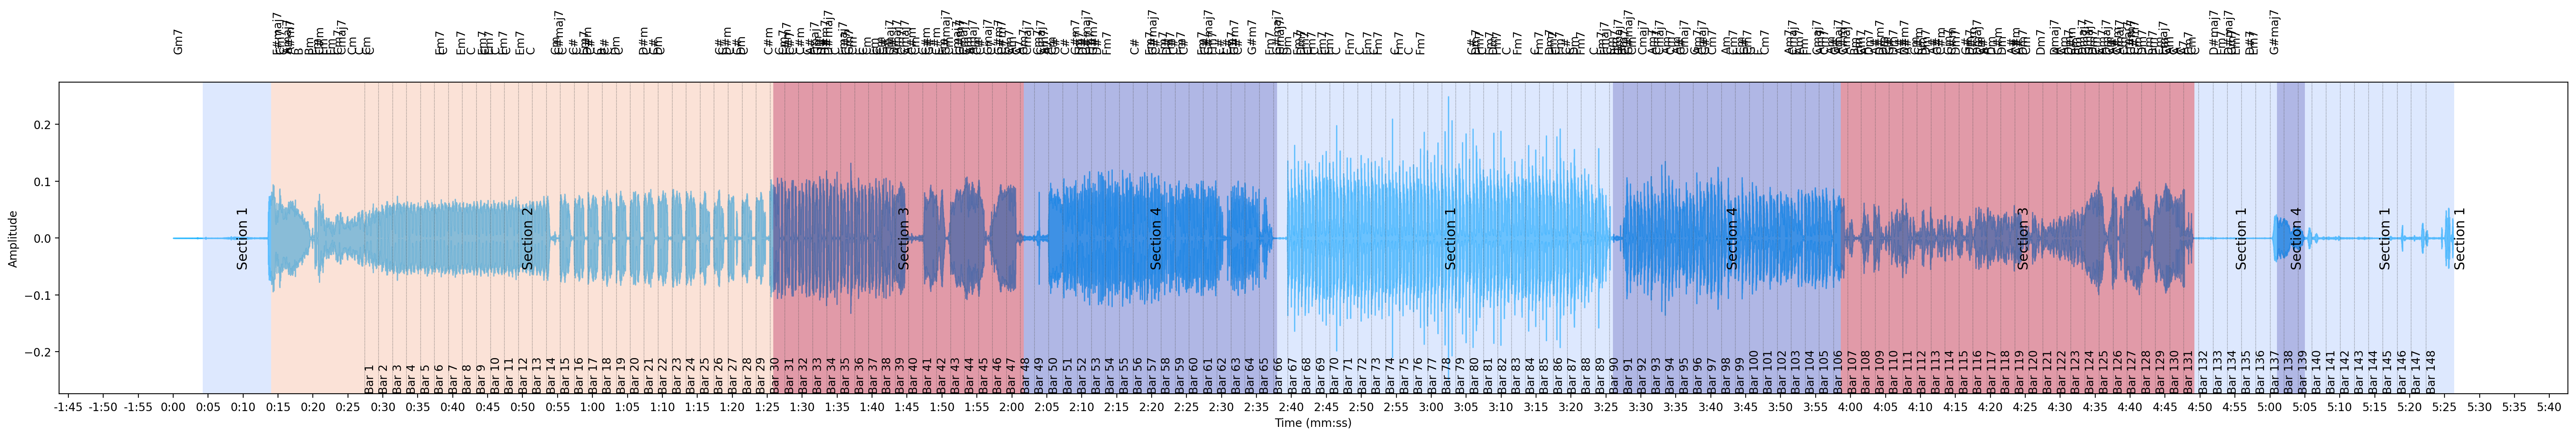

In [107]:
import plotMe
importlib.reload(plotMe)

data_dict = formData.populateDict(sr, chords, bars, bound_frames, bound_segs)

# Call the plotSpectrogram function
#plotMe.plotSpectrogram(sr, C, chords, bars, bound_frames, new_bound_segs, BINS_PER_OCTAVE, 40, 5)

plotMe.plotWaveform(y, data_dict['sr'], data_dict['chords'], data_dict['bars'], data_dict['bound_frames'], data_dict['bound_segs'], 40, 5, 'coolwarm') #last two numbers are the size of the plot in inches

# from IPython.display import Audio
# Audio(song)

In [95]:
#The array contains a dictionary [ChordChange(chord='N', timestamp=0.371519274), ChordChange(chord='C#m', timestamp=0.464399092), print only the chord
print([chord.chord for chord in chord_progression])

['N', 'Gmaj7', 'A', 'Bb', 'B', 'Cm', 'Abmaj7', 'C', 'Abmaj7', 'Gaug', 'G7', 'Ab6', 'G7', 'Fm7', 'Abmaj7', 'Aaug', 'C', 'Abmaj7', 'C#maj7', 'Ab', 'Gmaj7', 'Abmaj7', 'C6', 'Bm7b5', 'E7/G#', 'C', 'Ab6', 'Cm6', 'Gmaj7', 'Bbmaj7', 'Abmaj7', 'E/D', 'C', 'Dm7', 'B6', 'E7', 'B7', 'F6', 'G7/B', 'Bb6', 'Baug', 'Em7b5', 'Bm7', 'G/D', 'Bb/C', 'G7', 'Am7b5', 'Ab', 'F/C', 'C', 'Fmaj7', 'Fm7', 'C', 'F7', 'F6', 'Cmaj7', 'F/C', 'Cm', 'F7', 'F6', 'Fm7', 'C7', 'F7', 'Dm7b5/C', 'Fm7', 'Cdim', 'F/C', 'C', 'Bm7b5/A', 'Dmaj7', 'Bm', 'Dm', 'Ebmaj7', 'F#m7b5', 'B', 'Caug', 'Ebmaj7', 'Dm7', 'G7/B', 'Eb6', 'D', 'Fmaj7', 'Ebmaj7', 'Ebdim', 'Cm', 'Ebmaj7', 'D7', 'Ebm7b5/Db', 'Ebaug', 'Cm6', 'Dm7', 'Cdim', 'G7', 'Am7b5', 'C', 'Dm', 'Ebdim', 'C#7/E#', 'Ebmaj7', 'Fm7', 'N', 'Ab', 'C#', 'F', 'Bb', 'N']


In [96]:
#print the chords only
thisChord = [chord.chord for chord in chord_progression]
thisTimestamp = [chord.timestamp for chord in chord_progression]
print(len(thisChord), len(thisTimestamp))

#align both lists
final_CP = list(zip(thisChord, thisTimestamp))
print(final_CP)

106 106
[('N', 0.371519274), ('Gmaj7', 15.046530612), ('A', 15.696689341999999), ('Bb', 16.346848072), ('B', 17.182766439), ('Cm', 18.854603174), ('Abmaj7', 19.78340136), ('C', 21.269478458), ('Abmaj7', 29.257142857), ('Gaug', 39.102403628), ('G7', 50.15510204), ('Ab6', 58.79292517), ('G7', 59.535963718), ('Fm7', 79.598004535), ('Abmaj7', 85.82095238), ('Aaug', 87.399909297), ('C', 88.793106575), ('Abmaj7', 89.257505668), ('C#maj7', 90.836462585), ('Ab', 91.579501133), ('Gmaj7', 91.951020408), ('Abmaj7', 92.601179138), ('C6', 94.273015873), ('Bm7b5', 95.387573696), ('E7/G#', 95.75909297), ('C', 96.780770975), ('Ab6', 97.70956916), ('Cm6', 98.824126984), ('Gmaj7', 99.660045351), ('Bbmaj7', 100.4030839), ('Abmaj7', 100.867482993), ('E/D', 102.725079365), ('C', 104.582675736), ('Dm7', 107.276190476), ('B6', 108.762267573), ('E7', 111.64154195), ('B7', 112.013061224), ('F6', 112.477460317), ('G7/B', 113.127619047), ('Bb6', 114.613696145), ('Baug', 117.307210884), ('Em7b5', 117.864489795), 

In [97]:
#plotMe.plotSections(y, data_dict['sr'], data_dict['chords'], data_dict['bars'], data_dict['bound_frames'], data_dict['bound_segs'], 20, 5, 64) #20 and 5 are the size of the plot in inches, and 32 is the number of bars to plot

In [98]:
#plotMe.plotChordsBars(data_dict['chords'], data_dict['bars'], data_dict['bound_frames'], data_dict['bound_segs'])

In [99]:
#Get the tonality of the song
# Compute the chroma features using CQT
chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr)

# Sum chroma features over time to emphasize prominent pitches
chroma_vector = np.sum(chroma_cq, axis=1)
chroma_vector /= np.linalg.norm(chroma_vector)

# Modified Krumhansl-Schmuckler key profiles
major_profile = np.array([6.35, 2.23, 3.48, 2.33, 4.38, 4.09,
                          2.52, 5.19, 2.39, 3.66, 2.29, 2.88])
minor_profile = np.array([6.33, 2.68, 3.52, 5.38, 2.60, 3.53,
                          2.54, 4.75, 3.98, 2.69, 3.34, 3.17])

# Optionally adjust profiles
# minor_profile[0] *= 1.2  # Emphasize tonic in minor

# Normalize the profiles
major_profile /= np.linalg.norm(major_profile)
minor_profile /= np.linalg.norm(minor_profile)

key_names = ['C', 'C#', 'D', 'D#', 'E', 'F',
             'F#', 'G', 'G#', 'A', 'A#', 'B']
correlations = []

for i in range(12):
    # Rotate the key profiles
    major_profile_rotated = np.roll(major_profile, i)
    minor_profile_rotated = np.roll(minor_profile, i)

    # Compute the correlation with adjusted weights
    major_corr = np.dot(chroma_vector, major_profile_rotated) * 0.9
    minor_corr = np.dot(chroma_vector, minor_profile_rotated) * 1.1  # Increase minor influence

    correlations.append({
        'key': key_names[i],
        'mode': 'major',
        'correlation': major_corr
    })
    correlations.append({
        'key': key_names[i],
        'mode': 'minor',
        'correlation': minor_corr
    })

# Find the best matching key
best_match = max(correlations, key=lambda x: x['correlation'])
tonality = f"{best_match['key']} {best_match['mode']}"
print(f"Tonality: {tonality}")

# Sort correlations in descending order
correlations_sorted = sorted(correlations, key=lambda x: x['correlation'], reverse=True)
print("Correlation scores for all keys:")
for corr in correlations_sorted:
    print(f"{corr['key']} {corr['mode']}: {corr['correlation']:.4f}")


Tonality: F minor
Correlation scores for all keys:
F minor: 1.0553
E minor: 1.0466
C minor: 1.0449
D minor: 1.0303
G minor: 1.0268
C# minor: 1.0267
A minor: 1.0256
F# minor: 1.0216
D# minor: 1.0207
G# minor: 1.0161
B minor: 1.0106
A# minor: 1.0065
C major: 0.8551
G major: 0.8372
F major: 0.8356
G# major: 0.8355
C# major: 0.8325
D# major: 0.8274
D major: 0.8231
A# major: 0.8212
E major: 0.8192
B major: 0.8190
A major: 0.8144
F# major: 0.8139


In [100]:
from music21 import key, harmony, roman
from IPython.display import Audio

# Define the key context explicitly as C major
mykey = tonality.split(' ')[0]
mymode = tonality.split(' ')[1]
print(mykey, mymode)
song_key = key.Key(mykey, mymode)

#print(f"Key: {song_key.tonic.name} {song_key.mode}")

#The array contains a dictionary [ChordChange(chord='N', timestamp=0.371519274), ChordChange(chord='C#m', timestamp=0.464399092), save the tuple with the function and its location in the timestamp
functional_harmony = []

for chord_name, timestamp in (filtered_cp):
    if chord_name == 'N':
        # Skip any chords labeled as N
        functional_harmony.append(('N', timestamp))
        continue
    else:   
        # Create a ChordSymbol object to correctly interpret chord qualities
        chord_symbol = harmony.ChordSymbol(chord_name)
        
        # Convert the chord symbol to a Roman numeral based on the key
        roman_numeral = roman.romanNumeralFromChord(chord_symbol, song_key)
     
        # Append the Roman numeral and timestamp to the list
        functional_harmony.append((roman_numeral.figure, timestamp))
   
print(functional_harmony)

from IPython.display import Audio
Audio(song)

F minor


NameError: name 'filtered_cp' is not defined

In [ ]:
#get the name of folder where the data will be saved
myFolder = os.getcwd().split('src')[0]
thisPath = myFolder + collection + '/'
formData.saveData(data_dict, id_file, thisPath, tonality, functional_harmony)

In [ ]:
#compare final_CP and filtered_cp by aligning its timestamps
final = []
limit = 0.25 # Define the time limit for alignment

# Loop through each chord and timestamp in filtered_cp
for chord, timestamp in filtered_cp:
    match_found = False  # To check if a match is found within the limit
    
    # Loop through each chord and timestamp in final_CP
    for chord2, timestamp2 in chords:
        # Check if the timestamp2 is within the range defined by 'limit'
        if timestamp - limit < timestamp2 < timestamp + limit:
            final.append((chord, chord2, timestamp))
            match_found = True  # A match is found, no need to add 'N'
            break  # Exit the inner loop when a match is found
    
    # If no match was found in the inner loop, append 'N' as the second chord
    if not match_found:
        final.append((chord, 'N', timestamp))

# Print the final aligned chord list
for element in final:
    print(element)


('Bm', 'Am', 0.0)
('A', 'Dm', 2.043356009070295)
('Bm', 'E', 4.040272108843538)
('D', 'D', 5.7817687074829935)
('A', 'A', 6.222947845804988)
('G', 'Bm', 7.778684807256236)
('D', 'D', 9.496961451247165)
('A', 'A', 10.588299319727891)
('G', 'Bm', 11.493877551020407)
('A', 'D', 13.212154195011339)
('G', 'Am', 15.09297052154195)
('D', 'Dm', 17.41496598639456)
('G', 'Bm', 19.11002267573696)
('D', 'Dm', 21.199818594104308)
('Bm', 'Bm', 25.890249433106575)
('G', 'G', 27.70140589569161)
('Dm', 'Dm', 28.93206349206349)
('G', 'Bm', 30.67356009070295)
('Dm', 'D', 32.74013605442177)
('G', 'N', 34.27265306122449)
('D', 'Bm', 36.13024943310658)
('G', 'Bm7', 38.54512471655329)
('Dm', 'D', 40.4259410430839)
('G', 'G', 42.26031746031746)
('Am', 'Am', 45.255691609977326)
('Bm', 'B', 46.04517006802721)
('D', 'D', 48.01886621315193)
('A', 'A', 48.46004535147392)
('G', 'F#7', 49.412063492063496)
('Dm', 'N', 51.54829931972789)
('G', 'Bm', 53.661315192743764)
('F#m', 'F#m', 56.099410430839)
('E', 'E', 56.587

/tmp/ipykernel_443803/3748616781.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


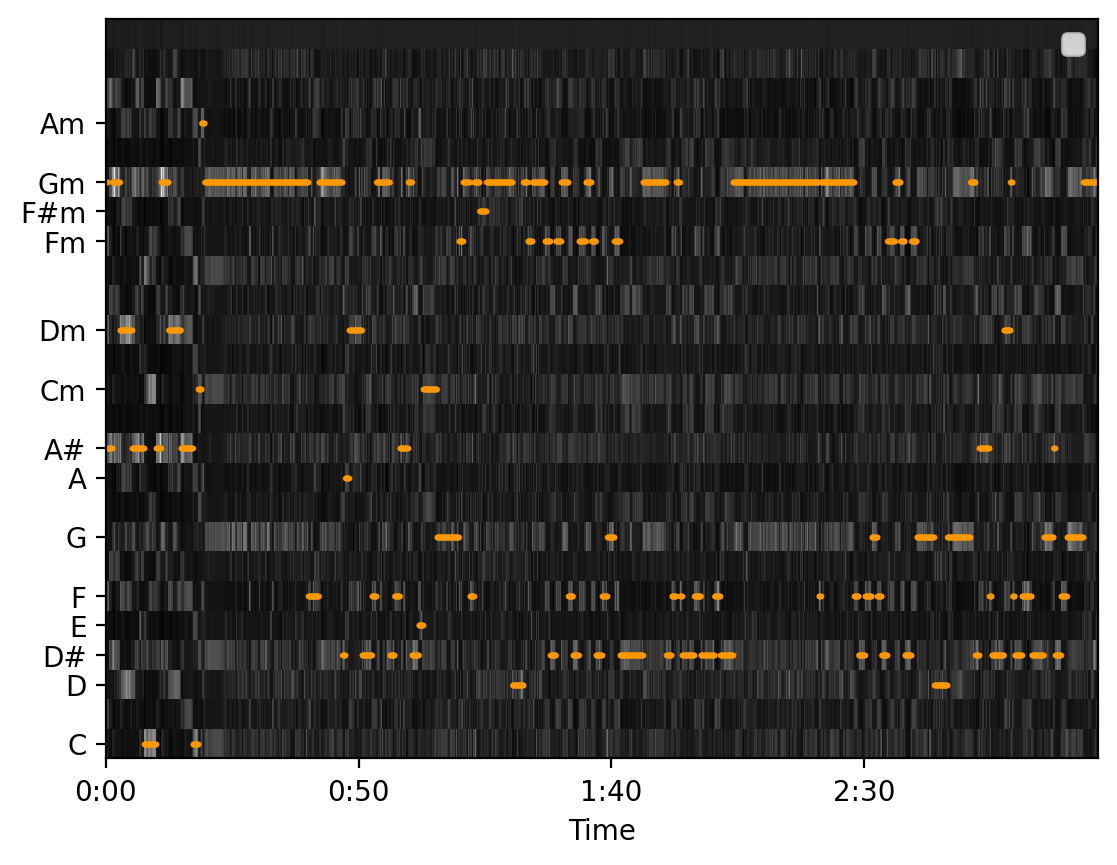

In [ ]:
# And plot the results
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (14,4)
fontsize=20
librosa.display.specshow(probs, x_axis='time', cmap='gray', ax=ax)
times = librosa.times_like(chords_vit)
ax.scatter(times, chords_vit, color='#ff9900', alpha=0.5, marker='o', s=1)
ax.set(yticks=np.unique(chords_vit), yticklabels=[labels[i] for i in np.unique(chords_vit)])
ax.legend()

Apply eigenface analysis. Make a average matrix segmentation. Scale all to 0 to 1. NMF 